In [1]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download sshubam/insat3d-infrared-raw-cyclone-images-20132021

Dataset URL: https://www.kaggle.com/datasets/sshubam/insat3d-infrared-raw-cyclone-images-20132021
License(s): CC0-1.0
  0% 0.00/43.2M [00:00<?, ?B/s]
100% 43.2M/43.2M [00:00<00:00, 962MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/insat3d-infrared-raw-cyclone-images-20132021.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [13]:
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")


In [14]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42)

NameError: name 'train' is not defined

In [19]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42)

In [22]:
train_data_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory="/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED",
    x_col="img_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=16,
    class_mode='raw'
)

test_data_gen = train_datagen.flow_from_dataframe(
    test_df,
    directory="/content/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED",
    x_col="img_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=16,
    class_mode='raw'
)


Found 108 validated image filenames.
Found 28 validated image filenames.


In [23]:
def build_model():
    base = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(512, 512, 3)))
    base.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(1, activation="linear")(bboxHead)

    model = Model(inputs=base.input, outputs=bboxHead)

    return model



In [24]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [25]:
save_best = ModelCheckpoint("Model.h5", monitor='loss', save_best_only=True, verbose=1)

In [26]:
history = model.fit(train_data_gen, epochs=50, callbacks=[save_best])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 39.7510 - root_mean_squared_error: 45.6739
Epoch 1: loss improved from inf to 30.99840, saving model to Model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 38.6569 - root_mean_squared_error: 44.6953
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - loss: 33.1004 - root_mean_squared_error: 39.4809
Epoch 2: loss improved from 30.99840 to 29.39873, saving model to Model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 32.6377 - root_mean_squared_error: 39.0443   
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - loss: 16.7579 - root_mean_squared_error: 21.2352
Epoch 3: loss improved from 29.39873 to 17.21869, saving model to Model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 16.8155 - root_mean_squared_error: 21.2833  
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16.9327 - root_mean_squared_error: 21.3048
Epoch 4: loss did not improve from 17.21869
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 17.0569 - root_mean_squared_error: 21.4935
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 18.5563 - root_mean_squared_error: 22.8172   
Epoch 5: loss did not improve from 17.21869
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 18.6422 - root_mean_squared_error: 22.8876
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - loss: 18.5379 - root_mean_squared_error: 24.4051
Epoch 6: loss did not improve from 17.21869
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 957ms/step - loss: 18.4850 - root_mean_squared_error: 24.3085
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 20.3226 - root_mean_squared_error: 25.4006
Epoch 7: loss did not improve from 17.21869
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 20.3612 - root_mean_squared

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 17.4538 - root_mean_squared_error: 20.8179  
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17.0075 - root_mean_squared_error: 21.3982
Epoch 10: loss improved from 17.07144 to 15.88938, saving model to Model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 16.8677 - root_mean_squared_error: 21.2608
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 19.4114 - root_mean_squared_error: 25.1111
Epoch 11: loss did not improve from 15.88938
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 19.1651 - root_mean_squared_error: 24.7926
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17.3549 - root_mean_squared_error: 21.8689
Epoch 12: loss improved from 15.88938 to 14.47983, saving model to Model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 16.9955 - root_mean_squared_error: 21.5115
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 16.5203 - root_mean_squared_error: 20.6012
Epoch 13: loss did not improve from 14.47983
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 16.8196 - root_mean_squared_error: 21.0545
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - loss: 14.4833 - root_mean_squared_error: 19.7058
Epoch 14: loss did not improve from 14.47983
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 970ms/step - loss: 14.6660 - root_mean_squared_error: 19.8185
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 17.4399 - root_mean_squared_error: 22.1261
Epoch 15: loss did not improve from 14.47983
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 17.1421 - root_mean_squared_error: 21.8273
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 14.7107 - root_mean_squared_error: 19.0345
Epoch 16: loss did not improve from 14.47983
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 14.6980 - root_mean_squa

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 12.5099 - root_mean_squared_error: 15.9704   
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 13.8289 - root_mean_squared_error: 17.2992
Epoch 18: loss did not improve from 12.50564
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 13.8779 - root_mean_squared_error: 17.3752
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 14.9707 - root_mean_squared_error: 19.0222
Epoch 19: loss did not improve from 12.50564
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 15.0949 - root_mean_squared_error: 19.1809
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 10.6947 - root_mean_squared_error: 13.7630
Epoch 20: loss improved from 12.50564 to 11.32434, saving model to Model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 10.7734 - root_mean_squared_error: 13.9055
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 14.3664 - root_mean_squared_error: 19.6125
Epoch 21: loss did not improve from 11.32434
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 14.2487 - root_mean_squared_error: 19.4487
Epoch 22/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 13.5315 - root_mean_squared_error: 17.3787
Epoch 22: loss did not improve from 11.32434
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 13.4855 - root_mean_squared_error: 17.2889
Epoch 23/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12.4475 - root_mean_squared_error: 15.9841
Epoch 23: loss improved from 11.32434 to 11.20208, saving model to Model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 12.2918 - root_mean_squared_error: 15.8125
Epoch 24/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11.9691 - root_mean_squared_error: 14.9414
Epoch 24: loss improved from 11.20208 to 10.85615, saving model to Model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 11.8300 - root_mean_squared_error: 14.8561
Epoch 25/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 11.1888 - root_mean_squared_error: 13.7150
Epoch 25: loss did not improve from 10.85615
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 11.2580 - root_mean_squared_error: 13.8894
Epoch 26/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - loss: 13.0282 - root_mean_squared_error: 17.5850
Epoch 26: loss did not improve from 10.85615
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 973ms/step - loss: 12.9706 - root_mean_squared_error: 17.4778
Epoch 27/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 14.3842 - root_mean_squared_error: 19.4861
Epoch 27: loss did not improve from 10.85615
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 14.1679 - root_mean_squared_error: 19.1432
Epoch 28/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 10.9335 - root_mean_squared_error: 14.1420
Epoch 28: loss did not improve from 10.85615
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 10.9737 - root_mean_squar

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 10.1438 - root_mean_squared_error: 13.4746
Epoch 36/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 13.2275 - root_mean_squared_error: 16.7995
Epoch 36: loss did not improve from 10.03426
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 13.0695 - root_mean_squared_error: 16.6336
Epoch 37/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - loss: 10.7909 - root_mean_squared_error: 14.5631
Epoch 37: loss did not improve from 10.03426
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 981ms/step - loss: 10.9613 - root_mean_squared_error: 14.7798
Epoch 38/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12.4713 - root_mean_squared_error: 17.0359
Epoch 38: loss did not improve from 10.03426
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 12.4215 - root_mean_squared_error: 16.9372
Epoch 39/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - loss: 9.8159 - root_mean_squared_error: 13.6725
Epoch 39: loss did not improve from 10.03426
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 961ms/step - loss: 9.9950 - root_mean_s

In [29]:
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError

# Load the model, explicitly specifying the loss and metric as custom objects
model = tf.keras.models.load_model(
    './Model.h5',
    custom_objects={'mae': tf.keras.losses.MeanAbsoluteError(),
                    'RootMeanSquaredError': RootMeanSquaredError()}
)

In [30]:
test_loss, test_rmse = model.evaluate(test_data_gen)
print(f"Testing Loss: {test_loss}, Testing RMSE: {test_rmse}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 13.9669 - root_mean_squared_error: 16.6894
Testing Loss: 14.838422775268555, Testing RMSE: 17.475894927978516


In [31]:
plt.figure(figsize=(20, 20))
for i in range(len(train_data_gen)):
    batch = train_data_gen[i]
    images = batch[0]
    labels = batch[1]
    for j in range(len(images)):
        cur_img = images[j]
        ax = plt.subplot(len(train_data_gen), len(images), i * len(images) + j + 1)
        plt.title("Training: "+str(labels[j]))
        plt.imshow(cur_img)
        plt.axis("off")


Output hidden; open in https://colab.research.google.com to view.

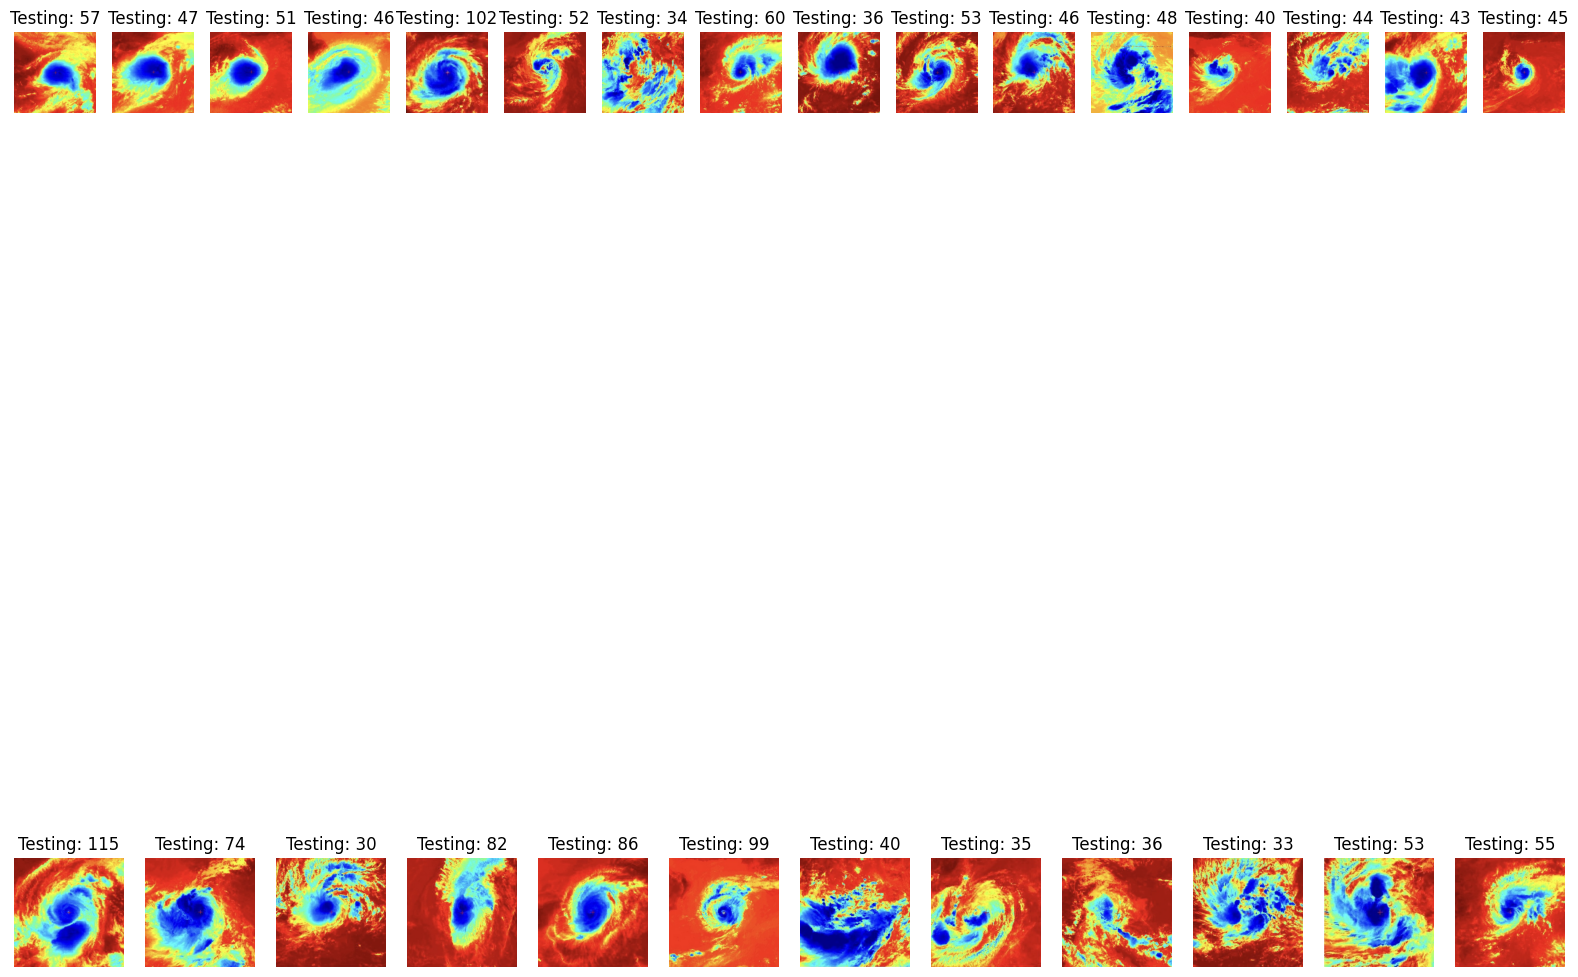

In [32]:
plt.figure(figsize=(20, 20))
for i in range(len(test_data_gen)):
    batch = test_data_gen[i]
    images = batch[0]
    labels = batch[1]
    for j in range(len(images)):
        cur_img = images[j]
        ax = plt.subplot(len(test_data_gen), len(images), i * len(images) + j + 1)
        plt.title("Testing: "+str(labels[j]))
        plt.imshow(cur_img)
        plt.axis("off")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


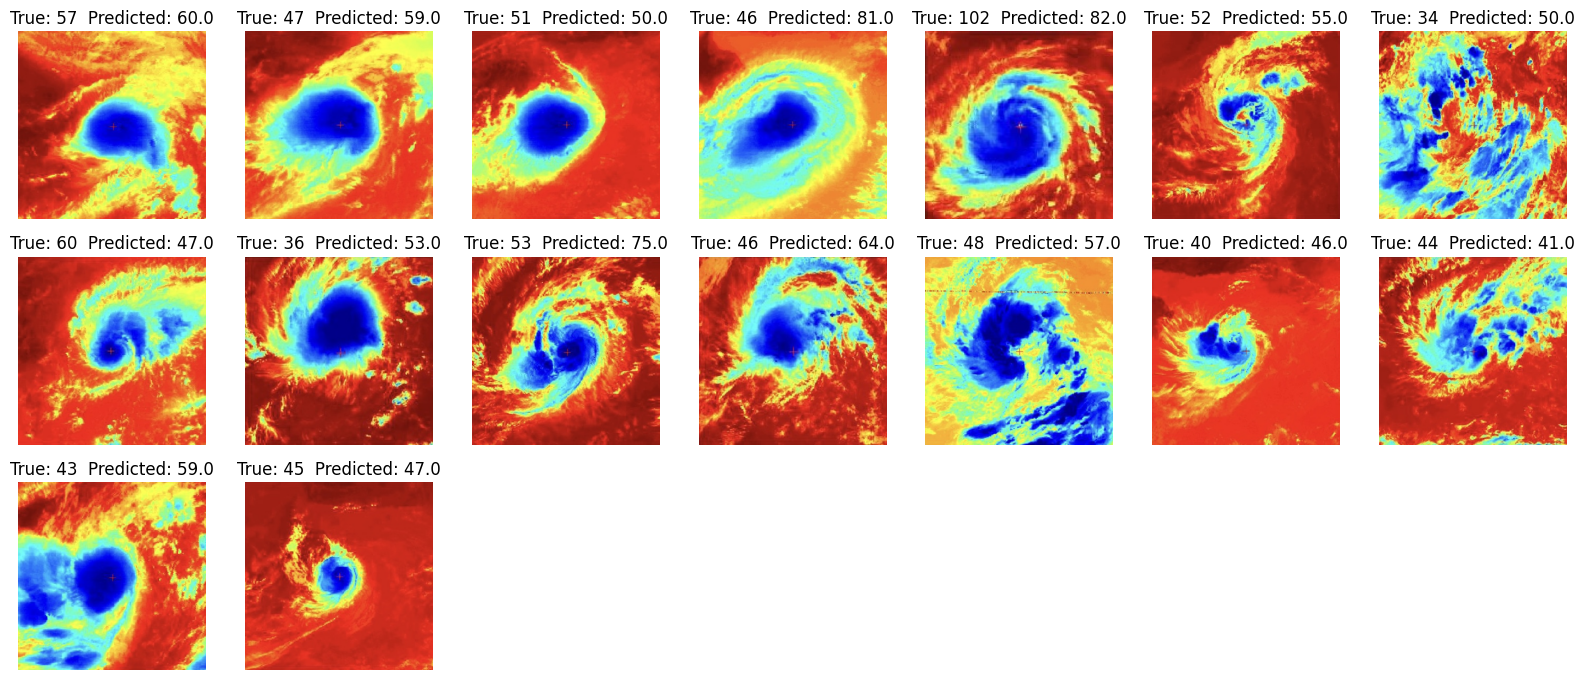

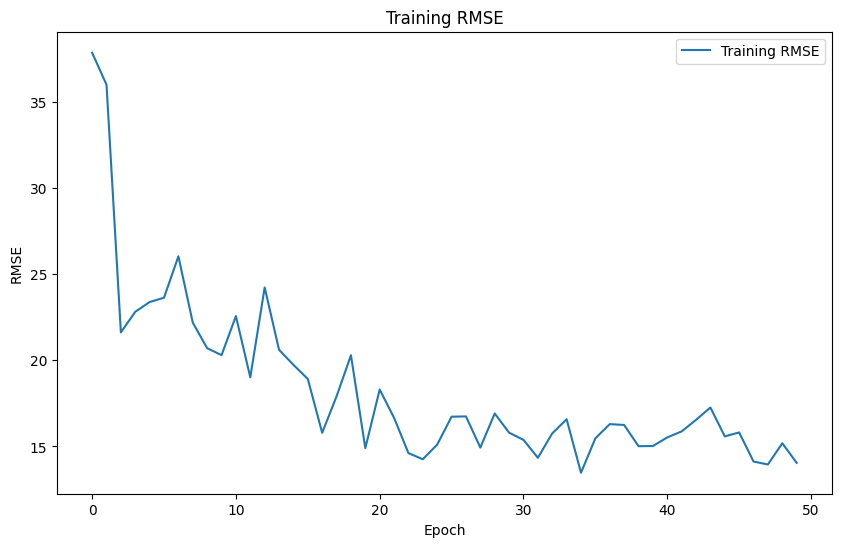

In [33]:
# Make predictions on the testing set
test_predictions = model.predict(test_data_gen)

# Plot some predictions
plt.figure(figsize=(20, 20))
for i in range(16):
    cur_img = test_data_gen[0][0][i]
    ax = plt.subplot(7, 7, i + 1)
    plt.title("True: "+str(test_data_gen[0][1][i])+"  Predicted: "+str(test_predictions[i][0].round()))
    plt.imshow(cur_img)
    plt.axis("off")
# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.title('Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()